# Feature Importance Analysis with XGBoost

* https://mljar.com/blog/feature-importance-xgboost/
* https://xgboost.readthedocs.io/en/stable/python/python_intro.html
* https://www.datacamp.com/community/tutorials/xgboost-in-python#apply

In [ ]:
import numpy as np
import pandas as pd

# from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

import xgboost as xgb
from xgboost import XGBClassifier

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pickle


In [ ]:
# mount data drive on colab
from google.colab import drive
drive.mount('/content/drive')

# set folder directories to load and save data
STATCAST_DATA_DIR = "/content/drive/MyDrive/final-project-dl/data/statcast/"
EMBEDDINGS_DATA_DIR = "/content/drive/MyDrive/final-project-dl/data/embeddings"

Mounted at /content/drive


In [ ]:
# Load in training data
train_df = pd.read_csv(STATCAST_DATA_DIR + 'train_data.csv', header=0)

In [ ]:
print(train_df.columns[:99])
print(train_df.columns[99:])

Index(['pitch_class', 'batter', 'pitcher', 'starter', 'recent_fourseam_usage',
       'recent_twoseam_usage', 'recent_cutter_usage', 'recent_slider_usage',
       'recent_curveball_usage', 'recent_changeup_usage',
       'long_term_fourseam_usage', 'long_term_twoseam_usage',
       'long_term_cutter_usage', 'long_term_slider_usage',
       'long_term_curveball_usage', 'long_term_changeup_usage',
       'Changeup_release_speed_m', 'Curveball_release_speed_m',
       'Cutter_release_speed_m', 'Fourseam_release_speed_m',
       'Slider_release_speed_m', 'Twoseam_release_speed_m',
       'Changeup_release_spin_rate_m', 'Curveball_release_spin_rate_m',
       'Cutter_release_spin_rate_m', 'Fourseam_release_spin_rate_m',
       'Slider_release_spin_rate_m', 'Twoseam_release_spin_rate_m',
       'Changeup_strike_per_m', 'Curveball_strike_per_m',
       'Cutter_strike_per_m', 'Fourseam_strike_per_m', 'Slider_strike_per_m',
       'Twoseam_strike_per_m', 'Changeup_whiff_per_m', 'Curveball_whiff

In [ ]:
# Load in embeddings

# load in batter embeddings reference table
with open(os.path.join(EMBEDDINGS_DATA_DIR, 'batter_embedding_df_v2.pkl'), 'rb') as f:
    batter_embedding_df = pickle.load(f)

# load in pitcher embeddings reference table
with open(os.path.join(EMBEDDINGS_DATA_DIR, 'pitcher_embedding_df_v2.pkl'), 'rb') as f:
    pitcher_embedding_df = pickle.load(f)

In [ ]:
# get the list of the batter column names from the embedding data frame
batter_cols = list(['batter_' + str(i) for i in range(9)]) # these are 9 dimensional embeddings
batter_cols.append('batter')

# get the list of the pitcher column names from the embedding data frame
pitcher_cols = list(['pitcher_' + str(i) for i in range(9)]) # these are 9 dimensional embeddings
pitcher_cols.append('pitcher')

In [ ]:
## Batter Embedding Integration ----

# get the existing statcast data row count
train_df_nrow = len(train_df)

# join the batter embeddings to the data
train_df = train_df.merge(batter_embedding_df[batter_cols], on='batter', how='left')

# get the new statcast data row count
train_df_batter_nrow = len(train_df)

# make sure the join doesn't produce duplicate records
print(train_df_nrow == train_df_batter_nrow)

True


In [ ]:
##### Pitcher Embedding Integration ----

# get the existing statcast data row count
train_df_nrow = len(train_df)

# join the pitcher embeddings to the data
train_df = train_df.merge(pitcher_embedding_df[pitcher_cols], on='pitcher', how='left')

# get the new statcast data row count
train_df_pitcher_nrow = len(train_df)

# make sure the join doesn't produce duplicate records
print(train_df_nrow == train_df_pitcher_nrow)

True


In [ ]:
# drop columns from data set we do not care about
train_df = train_df.drop(columns=['batter', 'pitcher', 'prev_game_pitch_number', 'prev_game_pitch_number', 'prev_game_pk', 'prev_pitch_number', 'prev_at_bat_number', 'game_pitch_number'])

In [ ]:
targets = train_df['pitch_class'].to_frame()

In [ ]:
# Assign each pitch with a unique index
pitch_to_ix = {"fourseam": 0, "twoseam": 1, "slider": 2,
               "changeup": 3, "curveball": 4, "cutter": 5}

# Convert the pitch code to the index for target data, y_train_df, y_valid_df
targets['class_num'] = train_df['pitch_class'].map(pitch_to_ix).to_frame()
# y_valid_gs = y_valid_df['pitch_class'].map(pitch_to_ix).to_frame()

In [ ]:
train_df_drop = train_df.iloc[:,1:]

In [ ]:
# ohe and no imputation
categorical_features = ['inning', 
                        'inning_topbot',
                        'outs_when_up',
                        'count',
                        'stand',
                        'p_throws',
                        'prev_pitch_class',
                        'prev_type',
                        'prev_events',
                        'prev_description',
                        'prev_bb_type',
                        'tto',]

# numeric and impute with 0
numerical_features = ['recent_fourseam_usage',
                      'recent_twoseam_usage',
                      'recent_cutter_usage',
                      'recent_slider_usage',
                      'recent_curveball_usage',
                      'recent_changeup_usage',
                      'long_term_fourseam_usage',
                      'long_term_twoseam_usage',
                      'long_term_cutter_usage',
                      'long_term_slider_usage',
                      'long_term_curveball_usage',
                      'long_term_changeup_usage',
                      'Changeup_release_speed_m',
                      'Curveball_release_speed_m',
                      'Cutter_release_speed_m',
                      'Fourseam_release_speed_m',
                      'Slider_release_speed_m',
                      'Twoseam_release_speed_m',
                      'Changeup_release_spin_rate_m',
                      'Curveball_release_spin_rate_m',
                      'Cutter_release_spin_rate_m',
                      'Fourseam_release_spin_rate_m',
                      'Slider_release_spin_rate_m',
                      'Twoseam_release_spin_rate_m',
                      'Changeup_strike_per_m',
                      'Curveball_strike_per_m',
                      'Cutter_strike_per_m',
                      'Fourseam_strike_per_m',
                      'Slider_strike_per_m',
                      'Twoseam_strike_per_m',
                      'Changeup_whiff_per_m',
                      'Curveball_whiff_per_m',
                      'Cutter_whiff_per_m',
                      'Fourseam_whiff_per_m',
                      'Slider_whiff_per_m',
                      'Twoseam_whiff_per_m',
                      'Changeup_woba_value_m',
                      'Curveball_woba_value_m',
                      'Cutter_woba_value_m',
                      'Fourseam_woba_value_m',
                      'Slider_woba_value_m',
                      'Twoseam_woba_value_m',
                      'batter_Changeup_whiff_per_m',
                      'batter_Curveball_whiff_per_m',
                      'batter_Cutter_whiff_per_m',
                      'batter_Fourseam_whiff_per_m',
                      'batter_Slider_whiff_per_m',
                      'batter_Twoseam_whiff_per_m',
                      'batter_Changeup_woba_value_m',
                      'batter_Curveball_woba_value_m',
                      'batter_Cutter_woba_value_m',
                      'batter_Fourseam_woba_value_m',
                      'batter_Slider_woba_value_m',
                      'batter_Twoseam_woba_value_m',
                      'bat_score',
                      'fld_score',
                      'on_1b',
                      'on_2b',
                      'on_3b',
                      'pitch_number',
                      'pitcher_pitch_number',
                      'prev_release_speed',
                      'prev_effective_speed',
                      'prev_release_pos_x',
                      'prev_release_pos_y',
                      'prev_release_pos_z',
                      'prev_vx0',
                      'prev_vy0',
                      'prev_vz0',
                      'prev_ax',
                      'prev_ay',
                      'prev_az',
                      'prev_pfx_x',
                      'prev_pfx_z',
                      'prev_release_spin_rate',
                      'prev_release_extension',
                      'prev_spin_axis',
                      'prev_plate_x',
                      'prev_plate_z',
                      'prev_hc_x',
                      'prev_hc_y',
                      'prev_hit_distance_sc',
                      'prev_launch_speed_angle',
                      'batter_0',
                      'batter_1',
                      'batter_2',
                      'batter_3',
                      'batter_4',
                      'batter_5',
                      'batter_6',
                      'batter_7',
                      'batter_8',
                      'pitcher_0',
                      'pitcher_1',
                      'pitcher_2',
                      'pitcher_3',
                      'pitcher_4',
                      'pitcher_5',
                      'pitcher_6',
                      'pitcher_7',
                      'pitcher_8']

In [ ]:
# ##### Data Pipelines ----

# # create pipeline for numeric features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0.0)),
        ('std_scaler', StandardScaler()),
    ])

# create pipeline for numeric features
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value="NA")),
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary')),
    ])

# # specify the column transformer for numeric features
data_pipeline = ColumnTransformer(
    [("num_pipeline", num_pipeline, numerical_features),
     ("cat_pipeline", cat_pipeline, categorical_features)],
    remainder='passthrough')

In [ ]:
X = pd.DataFrame(train_df_drop, columns=train_df_drop.columns)
y = targets['class_num']

In [ ]:
train_trans = data_pipeline.fit_transform(X[numerical_features + categorical_features])

In [ ]:
enc_cat_features = data_pipeline.named_transformers_['cat_pipeline']['ohe'].get_feature_names()
labels = np.concatenate([numerical_features, enc_cat_features])
transformed_df_columns = pd.DataFrame(train_trans, columns=labels).columns

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_df_trans = pd.DataFrame(train_trans, columns=transformed_df_columns)

In [ ]:
print(train_df_trans.columns[:99])
print(train_df_trans.columns[99:])

Index(['recent_fourseam_usage', 'recent_twoseam_usage', 'recent_cutter_usage',
       'recent_slider_usage', 'recent_curveball_usage',
       'recent_changeup_usage', 'long_term_fourseam_usage',
       'long_term_twoseam_usage', 'long_term_cutter_usage',
       'long_term_slider_usage', 'long_term_curveball_usage',
       'long_term_changeup_usage', 'Changeup_release_speed_m',
       'Curveball_release_speed_m', 'Cutter_release_speed_m',
       'Fourseam_release_speed_m', 'Slider_release_speed_m',
       'Twoseam_release_speed_m', 'Changeup_release_spin_rate_m',
       'Curveball_release_spin_rate_m', 'Cutter_release_spin_rate_m',
       'Fourseam_release_spin_rate_m', 'Slider_release_spin_rate_m',
       'Twoseam_release_spin_rate_m', 'Changeup_strike_per_m',
       'Curveball_strike_per_m', 'Cutter_strike_per_m',
       'Fourseam_strike_per_m', 'Slider_strike_per_m', 'Twoseam_strike_per_m',
       'Changeup_whiff_per_m', 'Curveball_whiff_per_m', 'Cutter_whiff_per_m',
       'Fourseam

In [ ]:
xgbc = XGBClassifier(n_estimators=500)

In [ ]:
train_dmatrix = xgb.DMatrix(data=train_df_trans, label=y)

In [ ]:
xgbc.fit(train_df_trans, y)

XGBClassifier(n_estimators=500, objective='multi:softprob')

In [ ]:
xgbc.feature_importances_

array([1.2434675e-01, 1.8764395e-01, 1.4627893e-01, 7.5667851e-02,
       1.1179585e-02, 3.5285201e-02, 1.9552682e-02, 1.7848512e-02,
       3.6165223e-02, 5.8165733e-02, 5.6544643e-02, 3.9571676e-02,
       9.0580533e-04, 1.8020207e-03, 3.1194494e-03, 7.2537654e-04,
       1.2047301e-03, 8.3607540e-04, 6.0160033e-04, 5.6976068e-04,
       6.6384615e-04, 4.7666102e-04, 7.1641529e-04, 1.1746329e-03,
       8.5040170e-04, 6.1453547e-04, 3.9147676e-04, 5.8110821e-04,
       9.6447999e-04, 4.7855778e-04, 1.1873480e-03, 1.0246192e-03,
       3.9556806e-04, 6.4980140e-04, 9.9118729e-04, 4.6821428e-04,
       7.5245887e-04, 6.8909460e-04, 4.0524019e-04, 6.6523242e-04,
       6.6915090e-04, 7.6985534e-04, 8.5058861e-04, 5.1306852e-04,
       4.7922466e-04, 5.7794322e-04, 1.0257553e-03, 3.4452483e-04,
       7.5875653e-04, 6.7854964e-04, 4.7524305e-04, 5.2031281e-04,
       3.4017774e-04, 4.9671112e-04, 1.6919152e-03, 5.4575398e-04,
       1.3474280e-03, 1.5980445e-03, 8.5466017e-04, 3.4559786e

Text(0.5, 1.0, 'XGBoost Feature Importance on Training Data with OHE Features included')

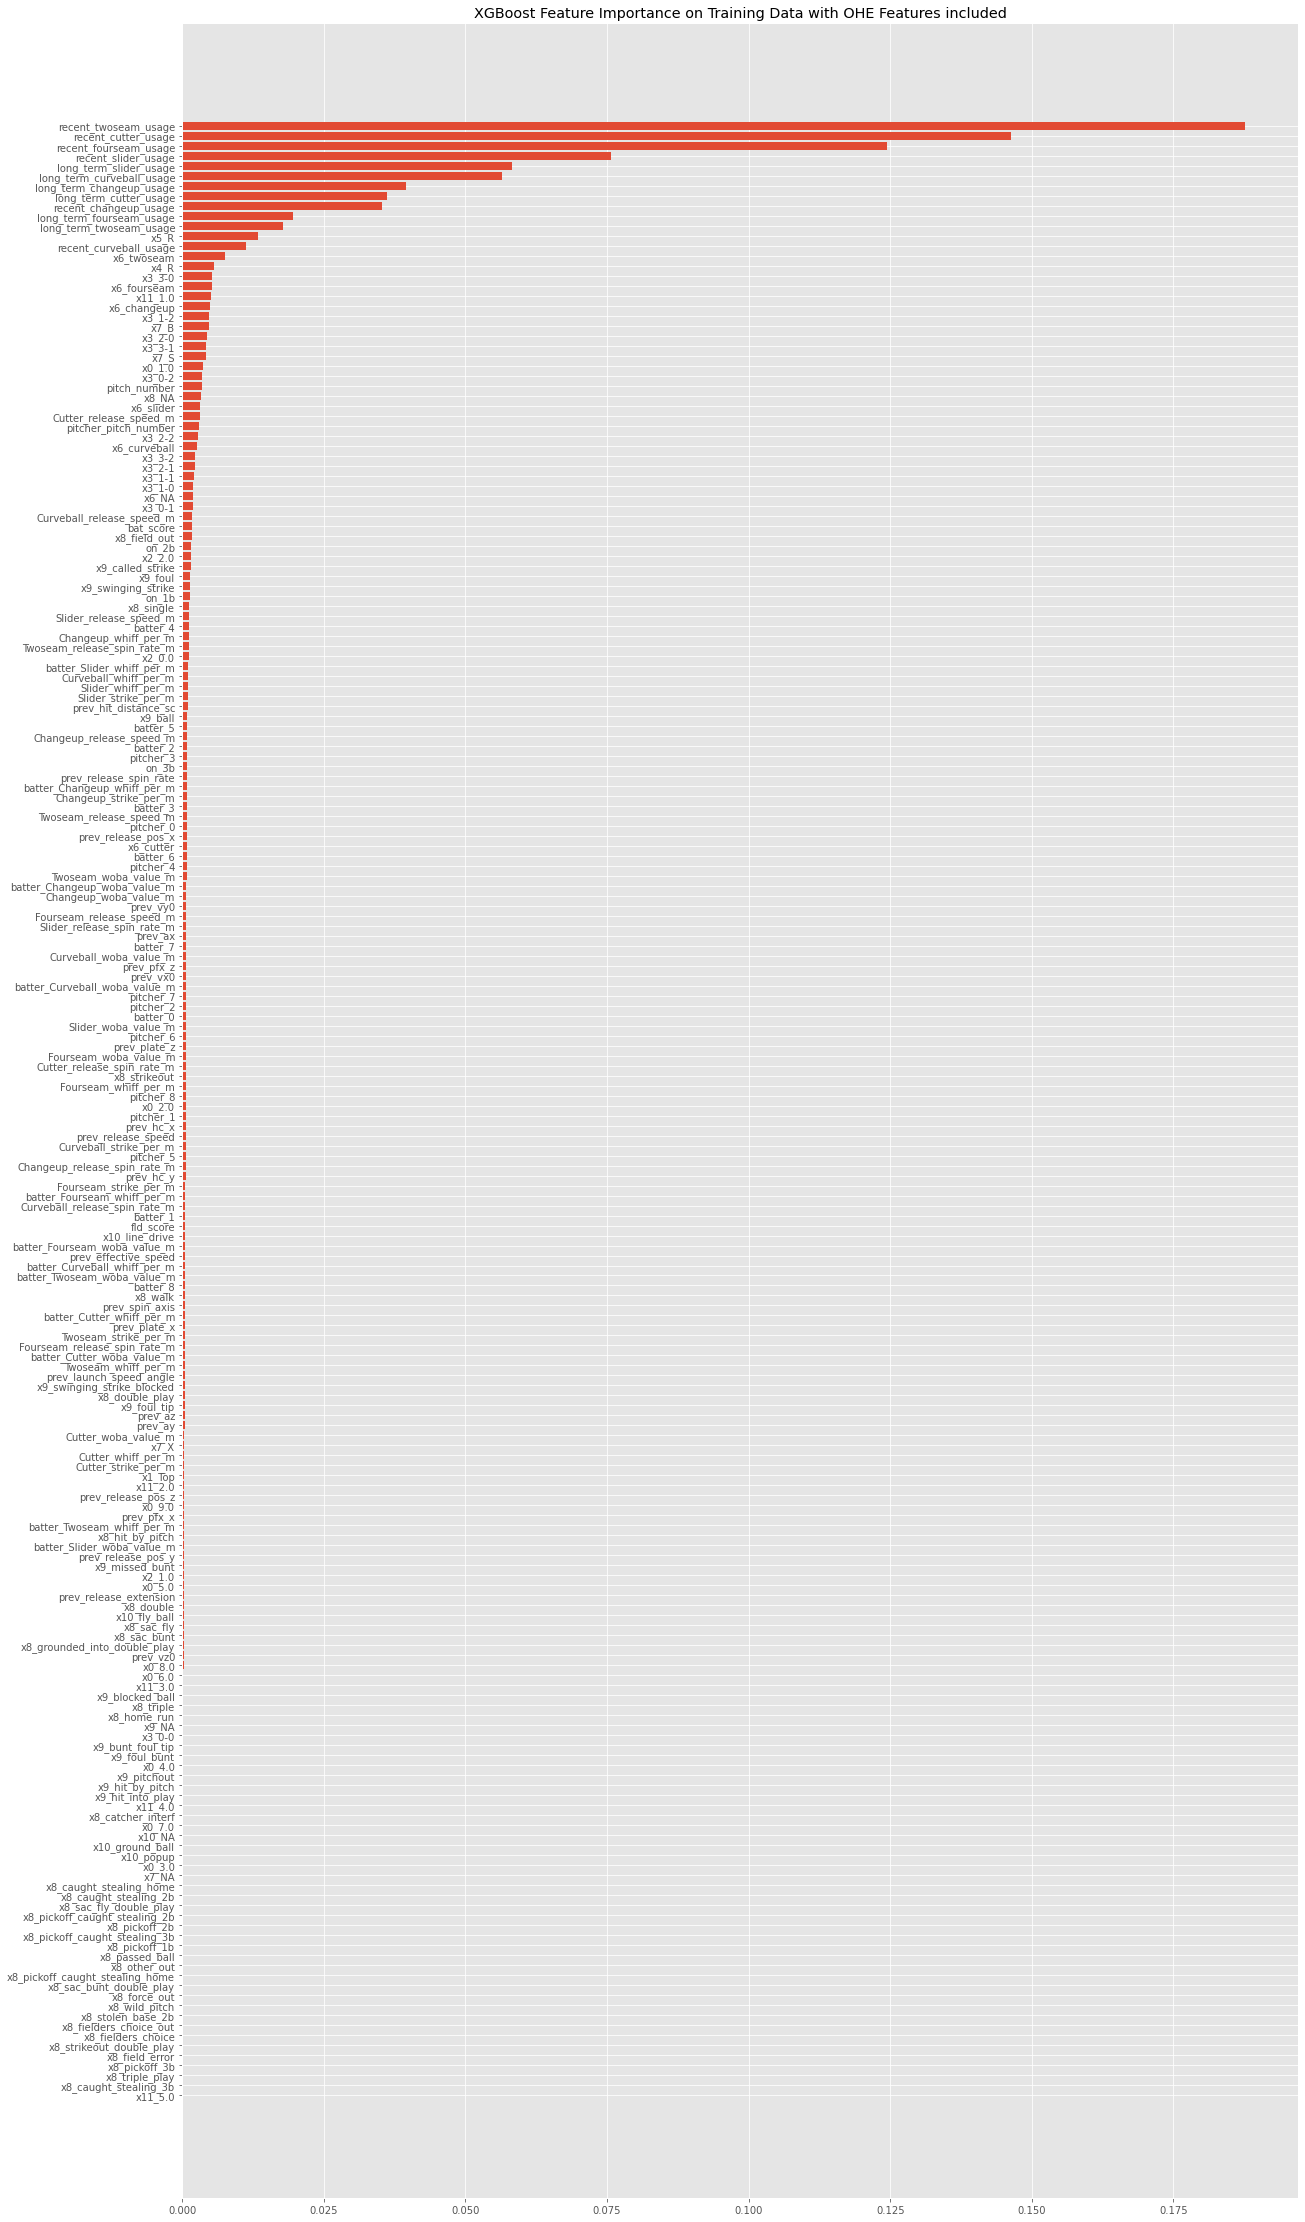

In [ ]:
sorted_idx = xgbc.feature_importances_.argsort()

plt.figure(figsize=(20,40))
plt.style.use('ggplot')

plt.barh(train_df_trans.columns[sorted_idx], xgbc.feature_importances_[sorted_idx])
plt.title("XGBoost Feature Importance on Training Data with OHE Features included")

In [ ]:
# Low importance features
low_imp_cols = train_df_trans.columns[xgbc.feature_importances_ < .0005]
print(len(low_imp_cols))
print(low_imp_cols)

83
Index(['Fourseam_release_spin_rate_m', 'Cutter_strike_per_m',
       'Twoseam_strike_per_m', 'Cutter_whiff_per_m', 'Twoseam_whiff_per_m',
       'Cutter_woba_value_m', 'batter_Cutter_whiff_per_m',
       'batter_Twoseam_whiff_per_m', 'batter_Cutter_woba_value_m',
       'batter_Slider_woba_value_m', 'batter_Twoseam_woba_value_m',
       'prev_release_pos_y', 'prev_release_pos_z', 'prev_vz0', 'prev_ay',
       'prev_az', 'prev_pfx_x', 'prev_release_extension', 'prev_spin_axis',
       'prev_plate_x', 'prev_launch_speed_angle', 'batter_8', 'x0_3.0',
       'x0_4.0', 'x0_5.0', 'x0_6.0', 'x0_7.0', 'x0_8.0', 'x0_9.0', 'x1_Top',
       'x2_1.0', 'x3_0-0', 'x7_NA', 'x7_X', 'x8_catcher_interf',
       'x8_caught_stealing_2b', 'x8_caught_stealing_3b',
       'x8_caught_stealing_home', 'x8_double', 'x8_double_play',
       'x8_field_error', 'x8_fielders_choice', 'x8_fielders_choice_out',
       'x8_force_out', 'x8_grounded_into_double_play', 'x8_hit_by_pitch',
       'x8_home_run', 'x8_other_

In [ ]:
# High importance features
high_imp_cols = train_df_trans.columns[xgbc.feature_importances_ >= .0005]
print(len(high_imp_cols))
print(high_imp_cols)

115
Index(['recent_fourseam_usage', 'recent_twoseam_usage', 'recent_cutter_usage',
       'recent_slider_usage', 'recent_curveball_usage',
       'recent_changeup_usage', 'long_term_fourseam_usage',
       'long_term_twoseam_usage', 'long_term_cutter_usage',
       'long_term_slider_usage',
       ...
       'x8_NA', 'x8_field_out', 'x8_single', 'x8_strikeout', 'x9_ball',
       'x9_called_strike', 'x9_foul', 'x9_swinging_strike', 'x10_line_drive',
       'x11_1.0'],
      dtype='object', length=115)


In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = train_df_trans.columns[sorted_idx]
feature_importance_df["importance"] = xgbc.feature_importances_[sorted_idx]
print(feature_importance_df)

                    feature  importance
0                   x11_5.0    0.000000
1     x8_caught_stealing_3b    0.000000
2            x8_triple_play    0.000000
3             x8_pickoff_3b    0.000000
4            x8_field_error    0.000000
..                      ...         ...
193  long_term_slider_usage    0.058166
194     recent_slider_usage    0.075668
195   recent_fourseam_usage    0.124347
196     recent_cutter_usage    0.146279
197    recent_twoseam_usage    0.187644

[198 rows x 2 columns]


In [ ]:
# Save results
feature_importance_df.to_csv(os.path.join("/content/drive/MyDrive/final-project-dl/data/", f'feature_importance.csv'), index = None, header=True)

In [ ]:
top_feats = xgbc.feature_importances_.argsort()[35:]

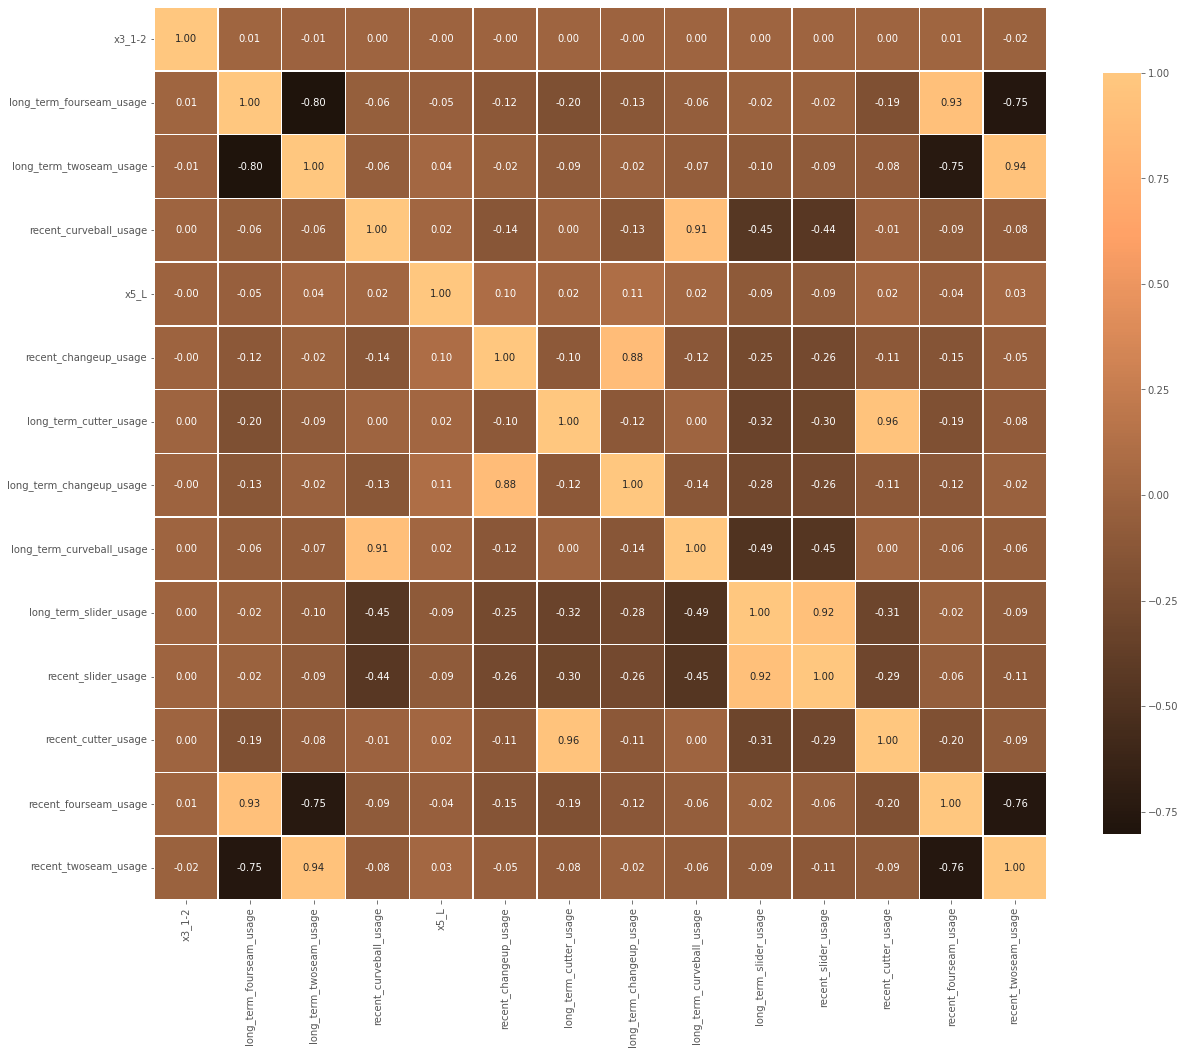

In [ ]:
# https://mljar.com/blog/feature-importance-xgboost/

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="copper",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(train_df_trans[transformed_df_columns[top_feats]])